In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_moons
import mlflow
import mlflow.sklearn
import optuna
from random import randint
import logging
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Base Models (+ ST assessor)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC#, SVR # kernels: 'linear', 'poly' e 'rbf'
from sklearn.neural_network import MLPClassifier
from kan import KANClassifier
from sklearn.ensemble import RandomForestClassifier#, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

/home/pbsl/pog/IC - Reject Option/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import json

with open('config.json', 'r') as f:
    CONFIG = json.load(f)

In [ ]:
def mlflow_log(model, train:list|tuple, valid:list|tuple, test:list|tuple, model_params:dict, model_reg:str, model_tag:str, display:list|tuple=None):
    with mlflow.start_run() as run:
        # accuracy, precision, recall, f1-score
        train_scores = getMetrics(train[1], model.predict(train[0]))
        valid_scores = getMetrics(valid[1], model.predict(valid[0]))

        test_pred = model.predict(test[0])
        test_scores = getMetrics(test[1], test_pred)
        cmatrix = confMatrix(test[1], test_pred, display=display)

        print(f'''
{str(list(model_params.values())[:-3])}

        \t\tTreinamento\t| Validação\t\t| Teste
Acurácia:\t{train_scores[0]}\t|  {valid_scores[0]}\t|  {test_scores[0]}
Precisão:\t{train_scores[1]}\t|  {valid_scores[1]}\t|  {test_scores[1]}
Recall:  \t{train_scores[2]}\t|  {valid_scores[2]}\t|  {test_scores[2]}
F1-Score:\t{train_scores[3]}\t|  {valid_scores[3]}\t|  {test_scores[3]}
''')
        mlflow.log_params(model_params)
        mlflow.log_metrics({'cross_val_score': max(k_scores_cross[model_tag]),
                            "train_accuracy": train_scores[0],
                            "train_precision": train_scores[1],
                            "train_recall": train_scores[2],
                            "train_f1_score": train_scores[3],
                            "valid_accuracy": valid_scores[0],
                            "valid_precision": valid_scores[1],
                            "valid_recall": valid_scores[2],
                            "valid_f1_score": valid_scores[3],
                            'test_accuracy': test_scores[0],
                            'test_precision': test_scores[1],
                            'test_recall': test_scores[2],
                            'test_f1_score': test_scores[3]
                            })
        mlflow.set_tag('clf', model_tag)
        mlflow.log_figure(cmatrix, 'conf_matrix.png')
        plt.close(cmatrix)

        run_id = run.info.run_id

        #tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        mlflow.sklearn.log_model(model, "model", registered_model_name=model_reg)

    return run_id

In [ ]:
def log_model_to_mlflow(model, model_name, hyperparams, X_train, y_train, X_test, y_test):
    """
    Treina, avalia e registra um modelo no MLflow.
    
    Parameters:
    -----------
    model : estimator
        Modelo do scikit-learn ou compatível
    model_name : str
        Nome do modelo para registro
    hyperparams : dict
        Dicionário com os hiperparâmetros do modelo
    X_train, y_train : array-like
        Dados de treino
    X_test, y_test : array-like
        Dados de teste
    """
    with mlflow.start_run(run_name=model_name):
        # Treinar modelo
        model.fit(X_train, y_train)
        
        # Fazer predições
        y_pred = model.predict(X_test)
        
        # Calcular probabilidades para AUROC (se disponível)
        try:
            if hasattr(model, 'predict_proba'):
                y_proba = model.predict_proba(X_test)
                # Para classificação binária
                if y_proba.shape[1] == 2:
                    auroc = roc_auc_score(y_test, y_proba[:, 1])
                # Para classificação multiclasse
                else:
                    auroc = roc_auc_score(y_test, y_proba)
            elif hasattr(model, 'decision_function'):
                y_scores = model.decision_function(X_test)
                if len(np.unique(y_test)) == 2:
                    auroc = roc_auc_score(y_test, y_scores)
                else:
                    auroc = roc_auc_score(y_test, y_scores)
            else:
                auroc = None
        except Exception as e:
            print(f"Aviso: Não foi possível calcular AUROC para {model_name}: {e}")
            auroc = None
        
        # Calcular métricas
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        
        # Registrar hiperparâmetros
        mlflow.log_params(hyperparams)
        
        # Registrar métricas
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        if auroc is not None:
            mlflow.log_metric("auroc", auroc)
        
        # Registrar modelo
        mlflow.sklearn.log_model(model, "model")
        
        print(f"\n{'='*60}")
        print(f"Modelo: {model_name}")
        print(f"{'='*60}")
        print(f"Acurácia:  {accuracy:.4f}")
        print(f"Precisão:  {precision:.4f}")
        print(f"Recall:    {recall:.4f}")
        print(f"F1-Score:  {f1:.4f}")
        if auroc is not None:
            print(f"AUROC:     {auroc:.4f}")
        print(f"{'='*60}\n")
        
        return model

In [ ]:
def load_model_by_name(experiment_name, run_name):
    """
    Carrega um modelo específico do MLflow pelo nome da run.
    
    Parameters:
    -----------
    experiment_name : str
        Nome do experimento MLflow
    run_name : str
        Nome da run (ex: "Random_Forest", "XGBoost")
    
    Returns:
    --------
    model : estimator
        Modelo carregado
    run_info : dict
        Informações da run (hiperparâmetros e métricas)
    """
    # Buscar experimento
    experiment = mlflow.get_experiment_by_name(experiment_name)
    if experiment is None:
        raise ValueError(f"Experimento '{experiment_name}' não encontrado!")
    
    # Buscar runs do experimento
    runs = mlflow.search_runs(
        experiment_ids=[experiment.experiment_id],
        filter_string=f"tags.mlflow.runName = '{run_name}'"
    )
    
    if runs.empty:
        raise ValueError(f"Run '{run_name}' não encontrada no experimento '{experiment_name}'!")
    
    # Pegar a run mais recente se houver múltiplas
    run = runs.iloc[0]
    run_id = run.run_id
    
    # Carregar modelo
    model_uri = f"runs:/{run_id}/model"
    model = mlflow.sklearn.load_model(model_uri)
    
    # Extrair informações da run
    run_info = {
        'run_id': run_id,
        'run_name': run_name,
        'start_time': run.start_time,
        'params': {k.replace('params.', ''): v for k, v in run.items() if k.startswith('params.')},
        'metrics': {k.replace('metrics.', ''): v for k, v in run.items() if k.startswith('metrics.')}
    }
    
    print(f"✓ Modelo '{run_name}' carregado com sucesso!")
    print(f"  Run ID: {run_id}")
    #print(f"  Métricas: F1={run_info['metrics'].get('f1_score', 'N/A'):.4f}")
    
    return model, run_info

In [ ]:
VERSION_NAME = 'v0'

SEED = 1246495320 #randint(0, 4294967295)
print(SEED)

mlflow.set_experiment(experiment_name=f'{VERSION_NAME}_{SEED}')

1246495320


- **Versões:**
  - v0: Versão inicial. Sem assessores. Apenas cálculo de confiança para rejeição por meio da probabilidade de classe dos modelos.

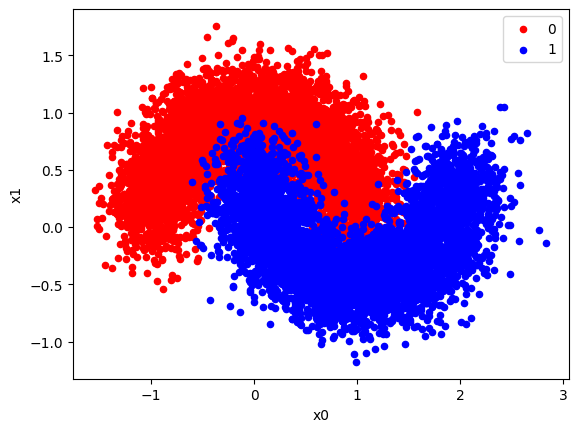

In [ ]:
# generate 2d classification dataset
X, y = make_moons(n_samples=CONFIG['TWO_MOONS']['N_SAMPLES'], 
                  noise=CONFIG['TWO_MOONS']['NOISE'], 
                  random_state=CONFIG['SEED'])
df = pd.DataFrame(dict(x0=X[:,0], x1=X[:,1], label=y))

# scatter plot, dots colored by class value
colors = {0:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x0', y='x1', label=key, color=colors[key])
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=SEED)

scaler = StandardScaler()

X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

In [ ]:
from train_models import load_model_by_name

def load_all_models(model_names):
    pass